![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Medical_Language_Models/April_2025/Notebooks/Dicom_Deidentification.ipynb)

<!-- ========================================================= -->
<!--        John Snow Labs - Package Installation Guide         -->
<!--        JupyterLab Single Markdown Cell (HTML Content)      -->
<!-- ========================================================= -->

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
# RESTART SESSION!!!

In [1]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


25/10/21 10:45:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


👌 Launched gpu optimized session with with: 🚀Spark-NLP==6.1.3, 💊Spark-Healthcare==6.1.1, 🕶Spark-OCR==6.1.0, running on ⚡ PySpark==3.4.0


<h1>Dicom Pixel DeIdentification</h1>

<!-- Notebook purpose -->
<p>
  This notebook demonstrates <strong>pixel-level de-identification</strong> in DICOM images using Named Entity Recognition (NER)</strong> outputs.</p>

<!-- Stages list -->
<h2>Concepts and Components Covered in this Notebook</h2>
<ul>
    <li>DicomToMetadata</li>
    <li>DicomToImageV3</li>
    <li>ImageTextDetector</li>
    <li>ImageToTextV3</li>
    <li>DicomDeidentifier</li>
    <li>PositionFinder</li>
    <li>ImageDrawRegions</li>
    <li>DicomDeidentifier</li>
    <li>DocumentAssembler</li>
    <li>SentenceDetectorDLModel</li>
    <li>Tokenizer</li>
    <li>WordEmbeddingsModel</li>
    <li>MedicalNerModel</li>
    <li>NerConverterInternal</li>
    <li>ChunkMergeApproach</li>
</ul>

In [2]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.schemas import BinarySchema

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *
from sparkocr.base import LightPipeline

from pyspark.sql.functions import *
from pyspark.sql.types import *
from urllib.parse import urlparse
from IPython.display import display, Markdown
from PIL import Image, ImageDraw, ImageFont
import pkg_resources
import pandas as pd
import time

In [ ]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr_text = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT_WITH_POSITIONS) \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(False) \
    .setUseCaching(True) \
    .setBatchSize(4)

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document") \
    .setCleanupMode("disabled")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("embeddings")

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
      .setInputCols(['sentence', 'token']) \
      .setOutputCol('embeddings_glove')

clinical_ner_glove = MedicalNerModel.pretrained("ner_deid_generic_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_glove")

ner_converter_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_glove"]) \
        .setOutputCol("ner_chunk_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_sub_glove = MedicalNerModel.pretrained("ner_deid_subentity_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_sub_glove")

ner_converter_sub_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_sub_glove"]) \
        .setOutputCol("ner_chunk_sub_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_multi = MedicalNerModel.pretrained("ner_deid_name_multilingual_clinical_langtest", "xx", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_multi")

ner_converter_multi = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_multi"]) \
        .setOutputCol("ner_chunk_multi") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_large = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_deid_large")

ner_converter_large = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_deid_large"]) \
        .setOutputCol("ner_chunk_large") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_chunk_glove', "ner_chunk_sub_glove", "ner_chunk_multi", "ner_chunk_large")\
    .setOutputCol('merged_ner_chunk') \
    .setMergeOverlapping(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

stages = [
    dicom_to_image,
    text_detector,
    ocr_text,
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    glove_embeddings,
    clinical_ner_glove,
    ner_converter_glove,
    clinical_ner_sub_glove,
    ner_converter_sub_glove,
    clinical_ner_multi,
    ner_converter_multi,
    clinical_ner_large,
    ner_converter_large,
    chunk_merger,
    position_finder
]

dicom_pipe = Pipeline(stages=stages)

In [6]:
stages

[DicomToImageV3_0f545bbca0b6,
 ImageTextDetectorCraft_4b473ae3c0f6,
 ImageToTextV2_7f0315d42bd2,
 DocumentAssembler_b44ffab28d61,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_431ceda7a20e,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_6dfeae3e18fb,
 MedicalNerModel_af9c2512011c,
 NerConverterInternalModel_88ce74e2bf4f,
 MedicalNerModel_2cb37763b81b,
 NerConverterInternalModel_06feee2ed191,
 MedicalNerModel_15975bb9777e,
 NerConverterInternalModel_7cdd172c747b,
 ChunkMergeApproach_9f0694ddc4ed,
 PositionFinder_5b1df7ee1a60]

<h3>Load a Single Dicom File and Extract Results</h3>

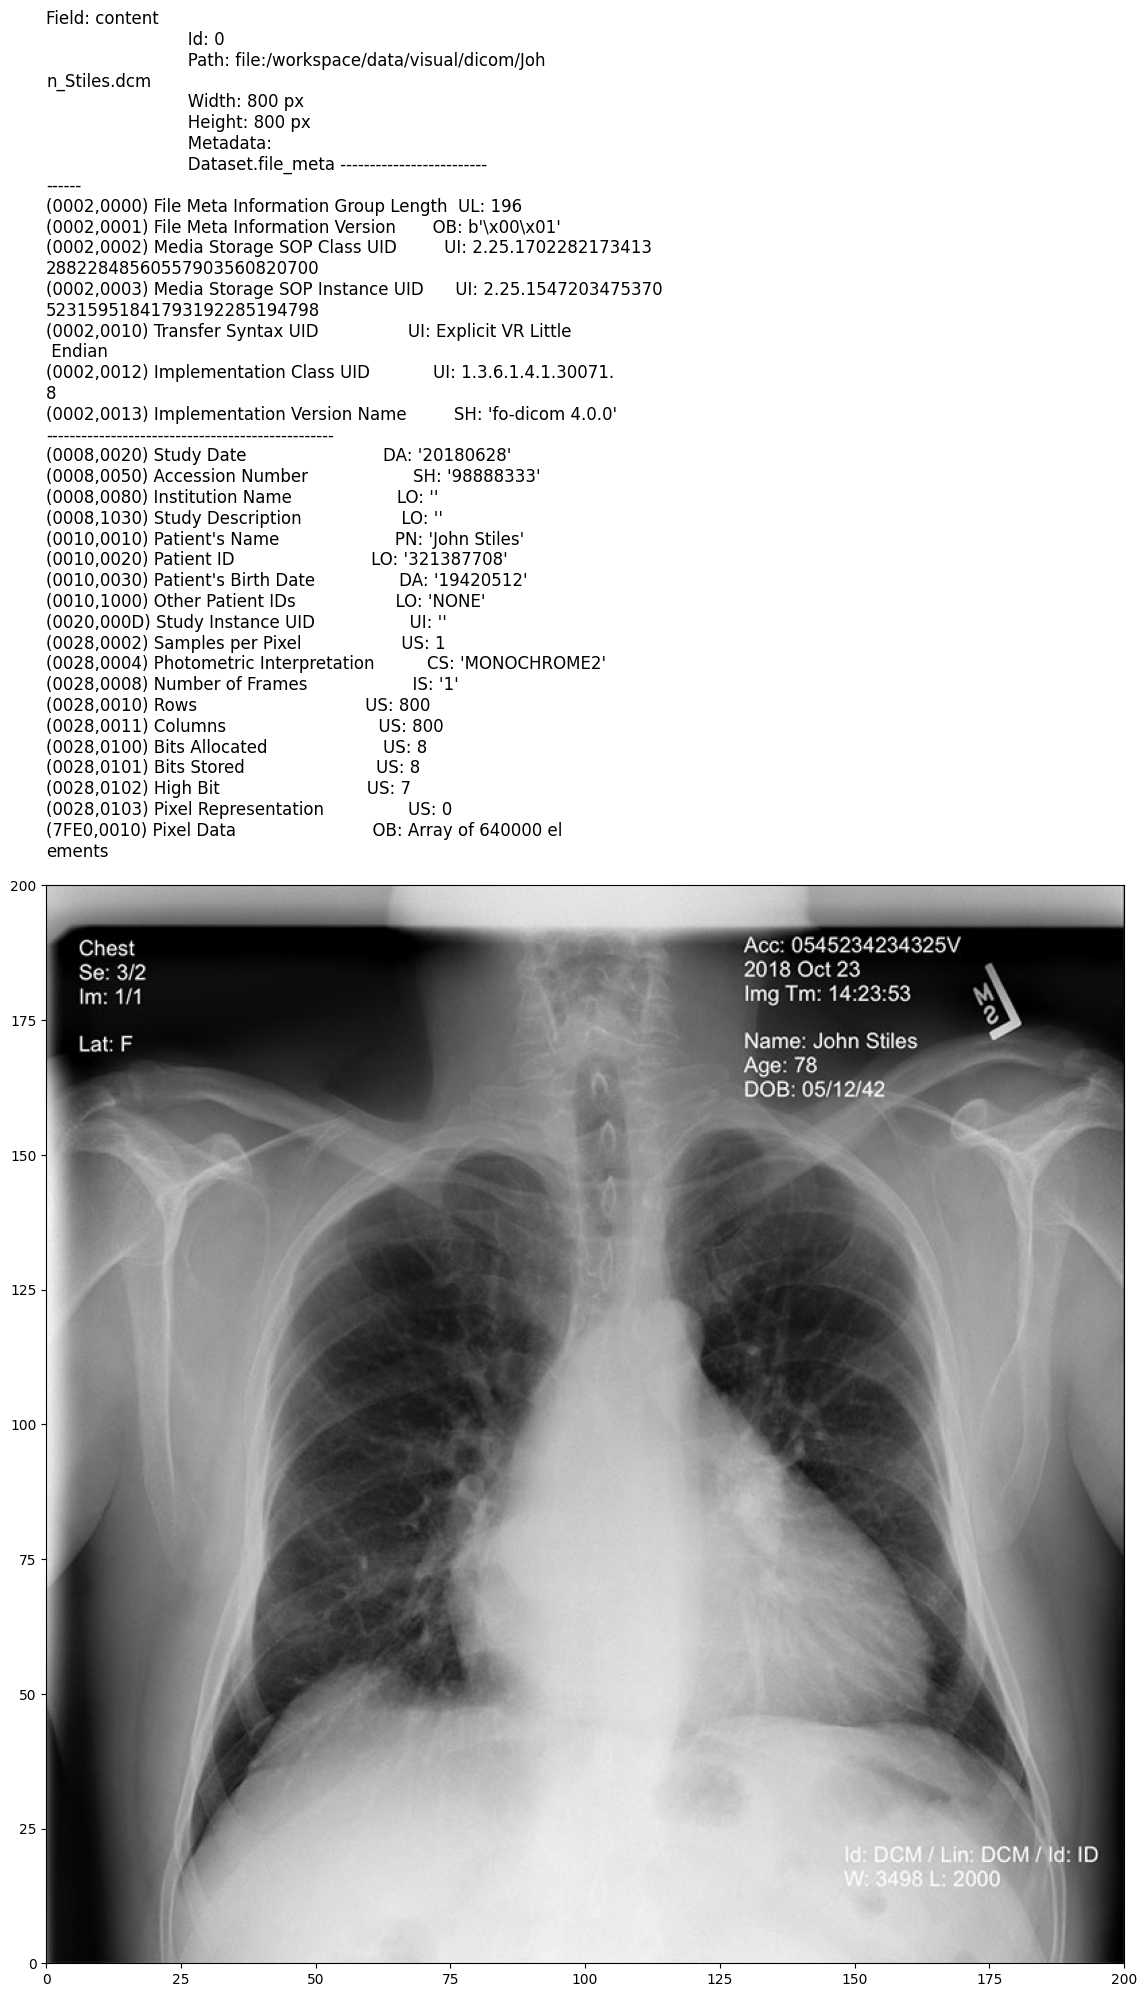

In [7]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/John_Stiles.dcm")

display_dicom(df, "content")

In [9]:
result = dicom_pipe.fit(df).transform(df).cache()

result.columns

25/10/21 10:56:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


['image_raw',
 'pagenum',
 'path',
 'modificationTime',
 'length',
 'content',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'exception',
 'document',
 'sentence',
 'token',
 'embeddings',
 'embeddings_glove',
 'ner_glove',
 'ner_chunk_glove',
 'ner_sub_glove',
 'ner_chunk_sub_glove',
 'ner_multi',
 'ner_chunk_multi',
 'ner_deid_large',
 'ner_chunk_large',
 'merged_ner_chunk',
 'coordinates']

<h2>Visualization of Detected Text Regions</h2>

In [10]:
# View the detected regions
result.select(F.explode("text_regions").alias("detected_regions")).show(50, False)

25/10/21 10:56:03 WARN DAGScheduler: Broadcasting large task binary with size 1901.0 KiB
/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_metadata_deidentifier.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
10:56:07, INFO Run DicomToImageV3
10:56:07, INFO DicomToImageV3: Number of frames: 1
10:56:07, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 190, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from 

+----------------------------------------------------------------------------+
|detected_regions                                                            |
+----------------------------------------------------------------------------+
|{0, 0, 597.0, 44.0, 16.0, 166.0, 0.99607843, 0, 90.0, true}                 |
|{0, 0, 46.0, 47.0, 14.0, 44.0, 0.99215686, 0, 90.0, true}                   |
|{0, 0, 561.0, 63.0, 14.0, 90.0, 0.99607843, 0, 90.0, true}                  |
|{0, 0, 48.0, 65.0, 18.0, 56.0, 0.9019608, 0, 90.0, true}                    |
|{0, 0, 579.0, 81.0, 18.0, 130.0, 0.9529412, 0, 90.0, true}                  |
|{0, 0, 699.0, 89.0, 34.0, 22.0, 0.90588236, 0, 90.0, true}                  |
|{0, 0, 49.0, 83.0, 14.0, 50.0, 0.81960785, 0, 90.0, true}                   |
|{0, 0, 582.0, 115.0, 18.0, 136.0, 0.99215686, 0, 90.0, true}                |
|{0, 0, 43.0, 118.0, 16.0, 46.0, 0.89411765, 0, 90.0, true}                  |
|{0, 0, 546.0, 137.0, 18.0, 60.0, 0.91764706, 0, 90.

25/10/21 10:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1907.6 KiB



    Image #0:
    Origin: file:/workspace/data/visual/dicom/John_Stiles.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: 10
    Number of channels: 1


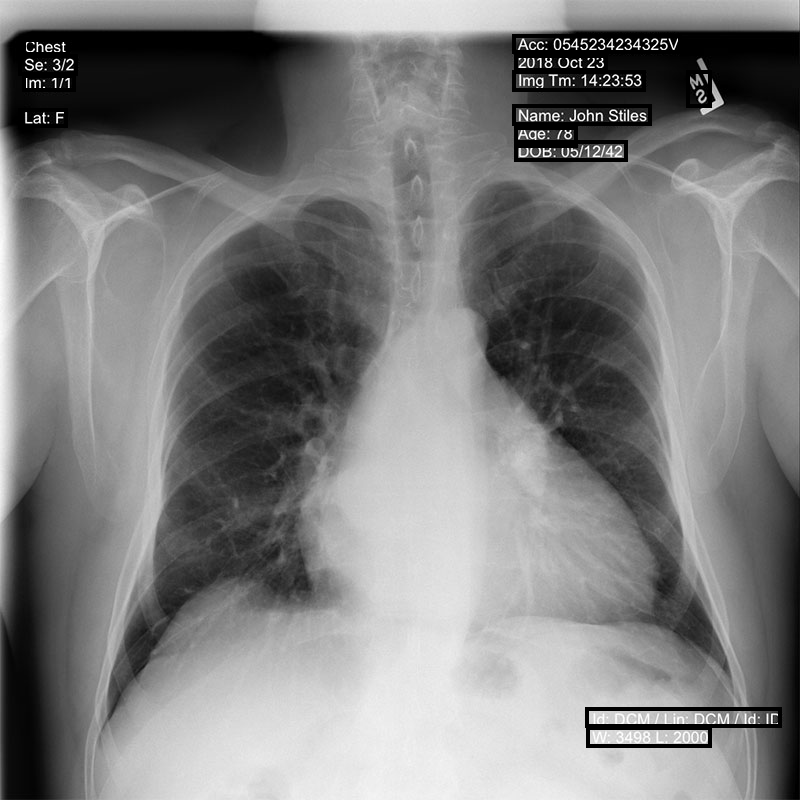

In [11]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("text_regions") \
  .setOutputCol("image_with_regions") \
  .setFilledRect(False)

display_images(draw.transform(result), "image_with_regions")

<h2>View NER Results</h2>

In [12]:
result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result, result.merged_ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+--------------+----------+-----------+
|ner_chunk     |confidence|chunk_class|
+--------------+----------+-----------+
|0545234234325V|0.9984    |ID         |
|2018          |0.9779    |DATE       |
|OCT 23        |0.8864    |DATE       |
|14:23:53      |0.9573    |ID         |
|JOHN STILES   |0.9779    |NAME       |
|78            |0.984     |AGE        |
|05/12/42      |1.0       |DATE       |
|DCM           |0.9985    |NAME       |
|LIN           |0.9999    |NAME       |
+--------------+----------+-----------+



25/10/21 10:56:59 WARN DAGScheduler: Broadcasting large task binary with size 1900.5 KiB


<h2>Deidentify the Pixels Using Coordinates</h2>

In [ ]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("coordinates") \
  .setRectColor(Color.red) \
  .setOutputCol("image_with_regions") \
  .setFilledRect(True)

display_images(draw.transform(result), "image_with_regions")


    Image #0:
    Origin: file:/workspace/data/visual/dicom/John_Stiles.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: 10
    Number of channels: 1


25/10/21 10:57:03 WARN DAGScheduler: Broadcasting large task binary with size 1907.6 KiB


<h2>Complete DICOM PHI Deidentification Pipeline Construction</h2>

<ol>
    <li>
        <strong>Final Deidentification Stages:</strong>
        <ul>
            <li>To complete the pipeline, we add two critical stages: <code>DicomDrawRegions</code> and <code>DicomMetadataDeidentifier</code>.</li>
            <li><strong><code>DicomDrawRegions</code>:</strong> This stage performs pixel-level redaction by drawing regions over identified PHI. Importantly, this stage aggregates and consolidates results, effectively removing intermediate result columns from previous stages.</li>
            <li><strong><code>DicomMetadataDeidentifier</code>:</strong> This stage ensures comprehensive deidentification by removing or modifying sensitive information present in the DICOM metadata tags.</li>
        </ul>
    </li>
</ol>

<p>By including these final stages, we construct a complete pipeline capable of both identifying and removing PHI from DICOM image pixel data and metadata, ensuring thorough deidentification.</p>

In [ ]:
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom_cleaned") \
    .setAggCols(["path"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom_cleaned"]) \
    .setOutputCol("dicom_meta_cleaned")\
    .setKeepInput(True)

full_stages = stages.copy()

full_stages.append(draw_regions)
full_stages.append(dicom_deidentifier)

dicom_full_pipe = Pipeline(stages=full_stages)

In [ ]:
full_stages

[DicomToImageV3_c3996317d911,
 ImageTextDetectorCraft_1be80ee1b9a0,
 ImageToTextV2_5c05f20c086d,
 DocumentAssembler_2911d7f52535,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_df5e49de620c,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_ceb23228a8d0,
 MedicalNerModel_af9c2512011c,
 NerConverterInternalModel_c9d3b54793cc,
 MedicalNerModel_2cb37763b81b,
 NerConverterInternalModel_8941f4159465,
 MedicalNerModel_15975bb9777e,
 NerConverterInternalModel_6c5b7aef5f80,
 ChunkMergeApproach_dc7077cf5345,
 PositionFinder_d8aa3b413168,
 DicomDrawRegions_b7607179c055,
 DicomMetadataDeidentifier_18976545d76d]

<h2>Example 1: Deidentifying David Douglas's DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/visual/dicom/David_Douglas.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/david_douglas/</code></p>

In [ ]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/David_Douglas.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/david_douglas/")

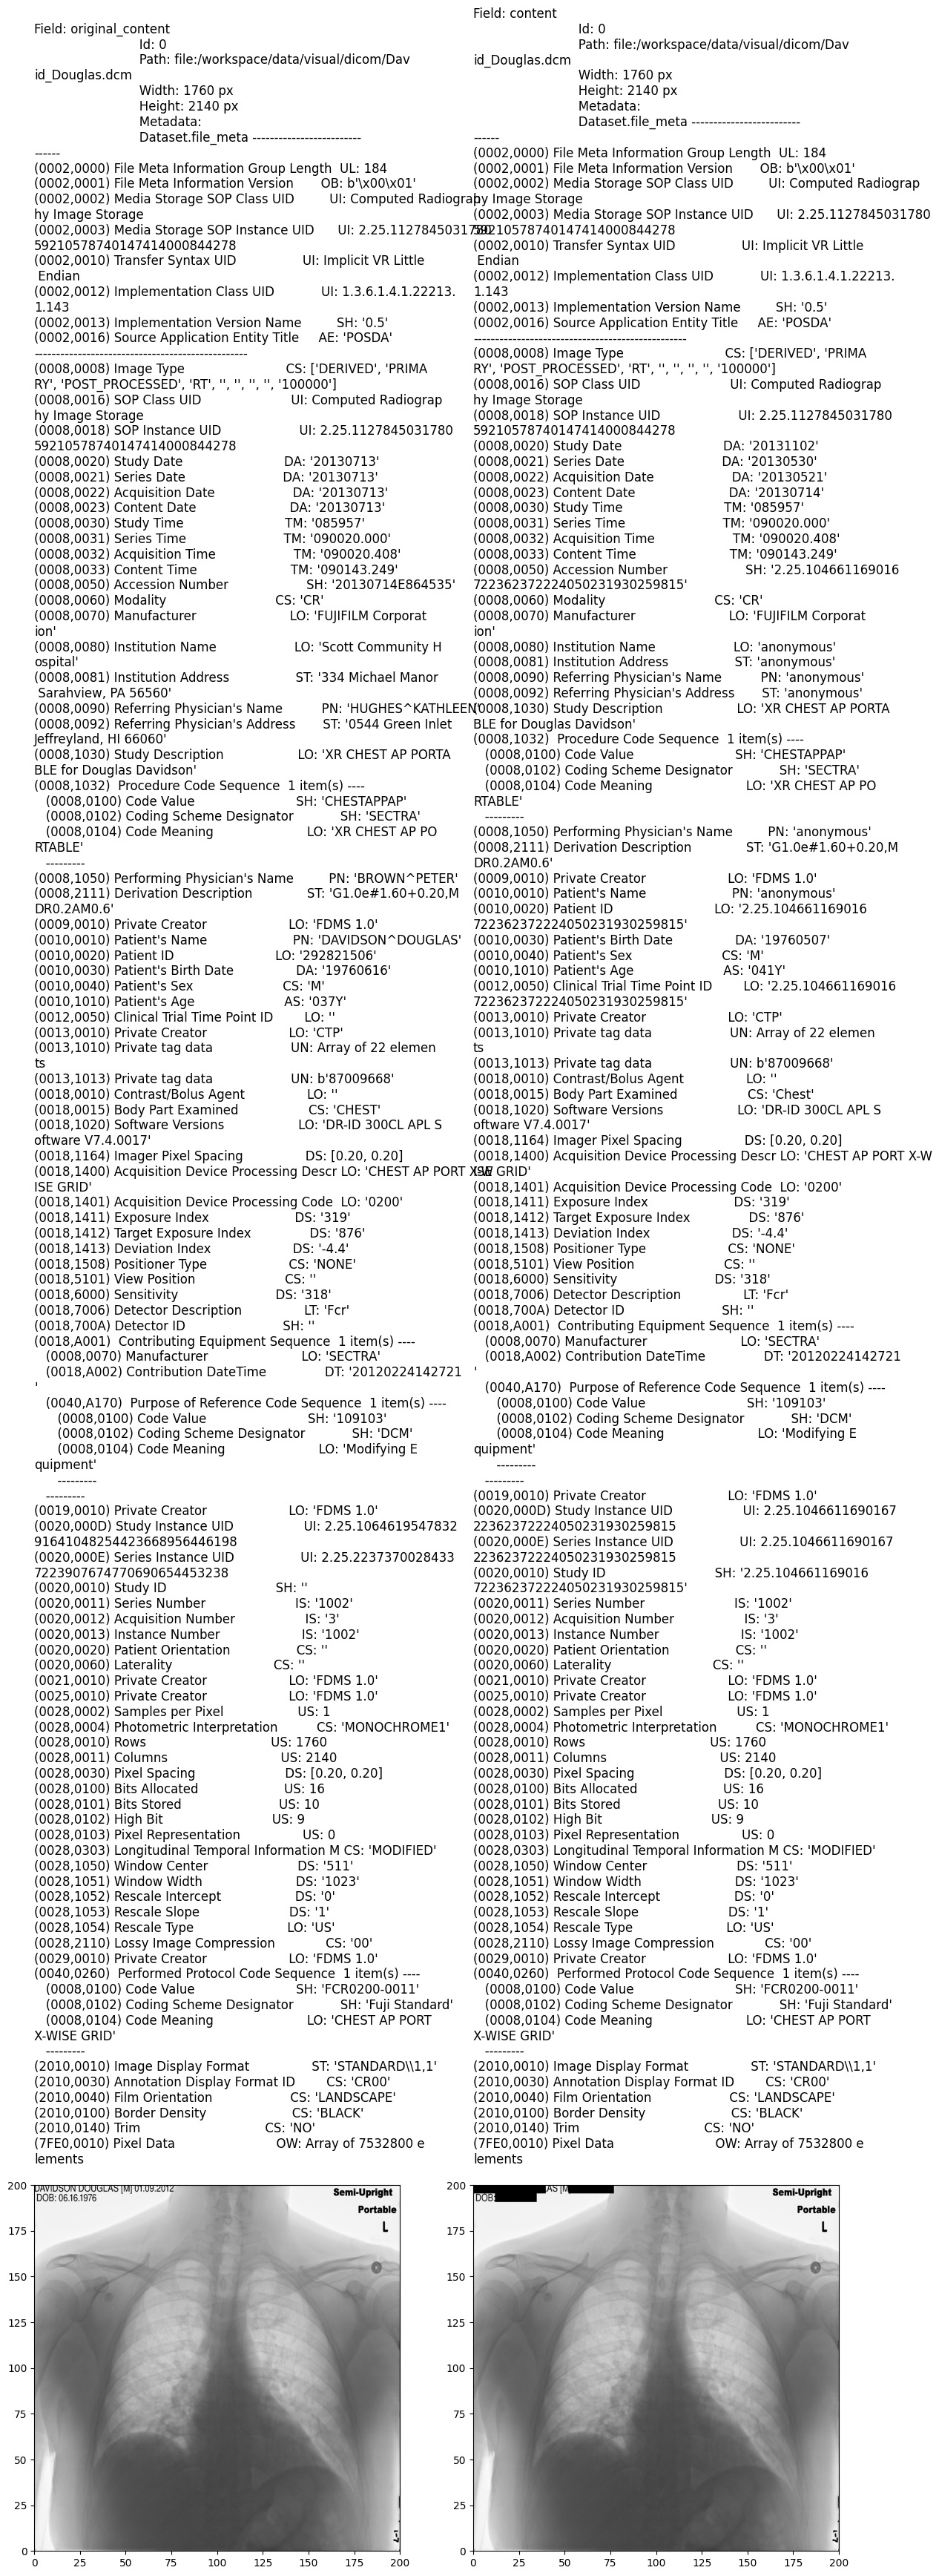

In [19]:
df = spark.read.format("binaryFile").load("./data/result/david_douglas/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/visual/dicom/David_Douglas.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

<h2>Example 2: Deidentifying Martin Chad Douglas's DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>/data/visual/dicom/Martin_Chad.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/martin_chad/</code></p>

In [ ]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/Martin_Chad.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/martin_chad/")

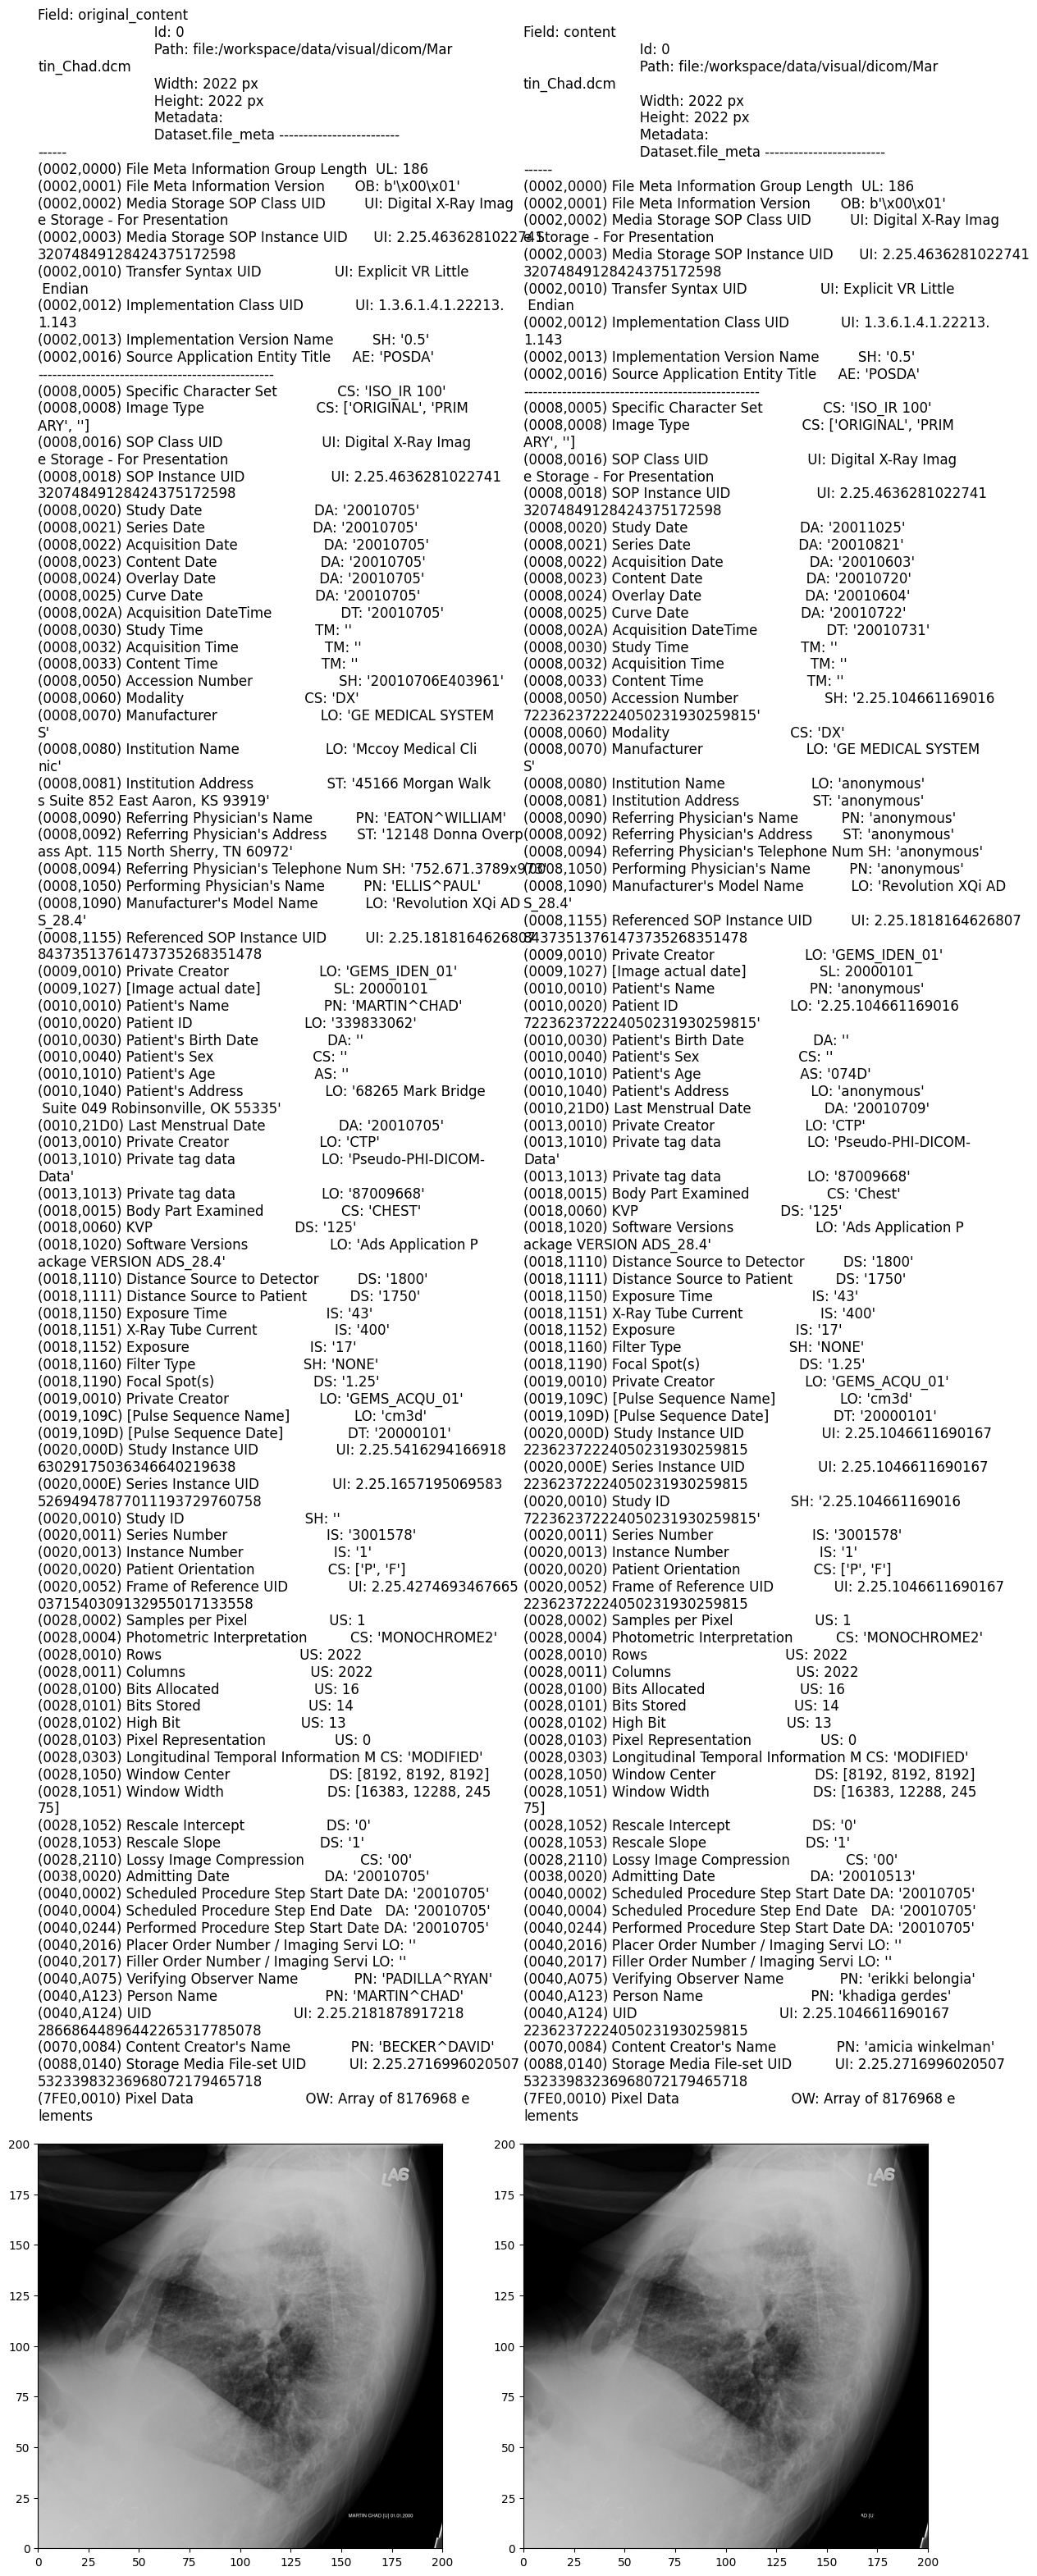

In [21]:
df = spark.read.format("binaryFile").load("./data/result/martin_chad/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/visual/dicom/Martin_Chad.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

<h2>Example 3: Deidentifying Good Guy's DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/visual/dicom/Good_Guy.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/good_guy/</code></p>

In [ ]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/Good_Guy.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/good_guy/")

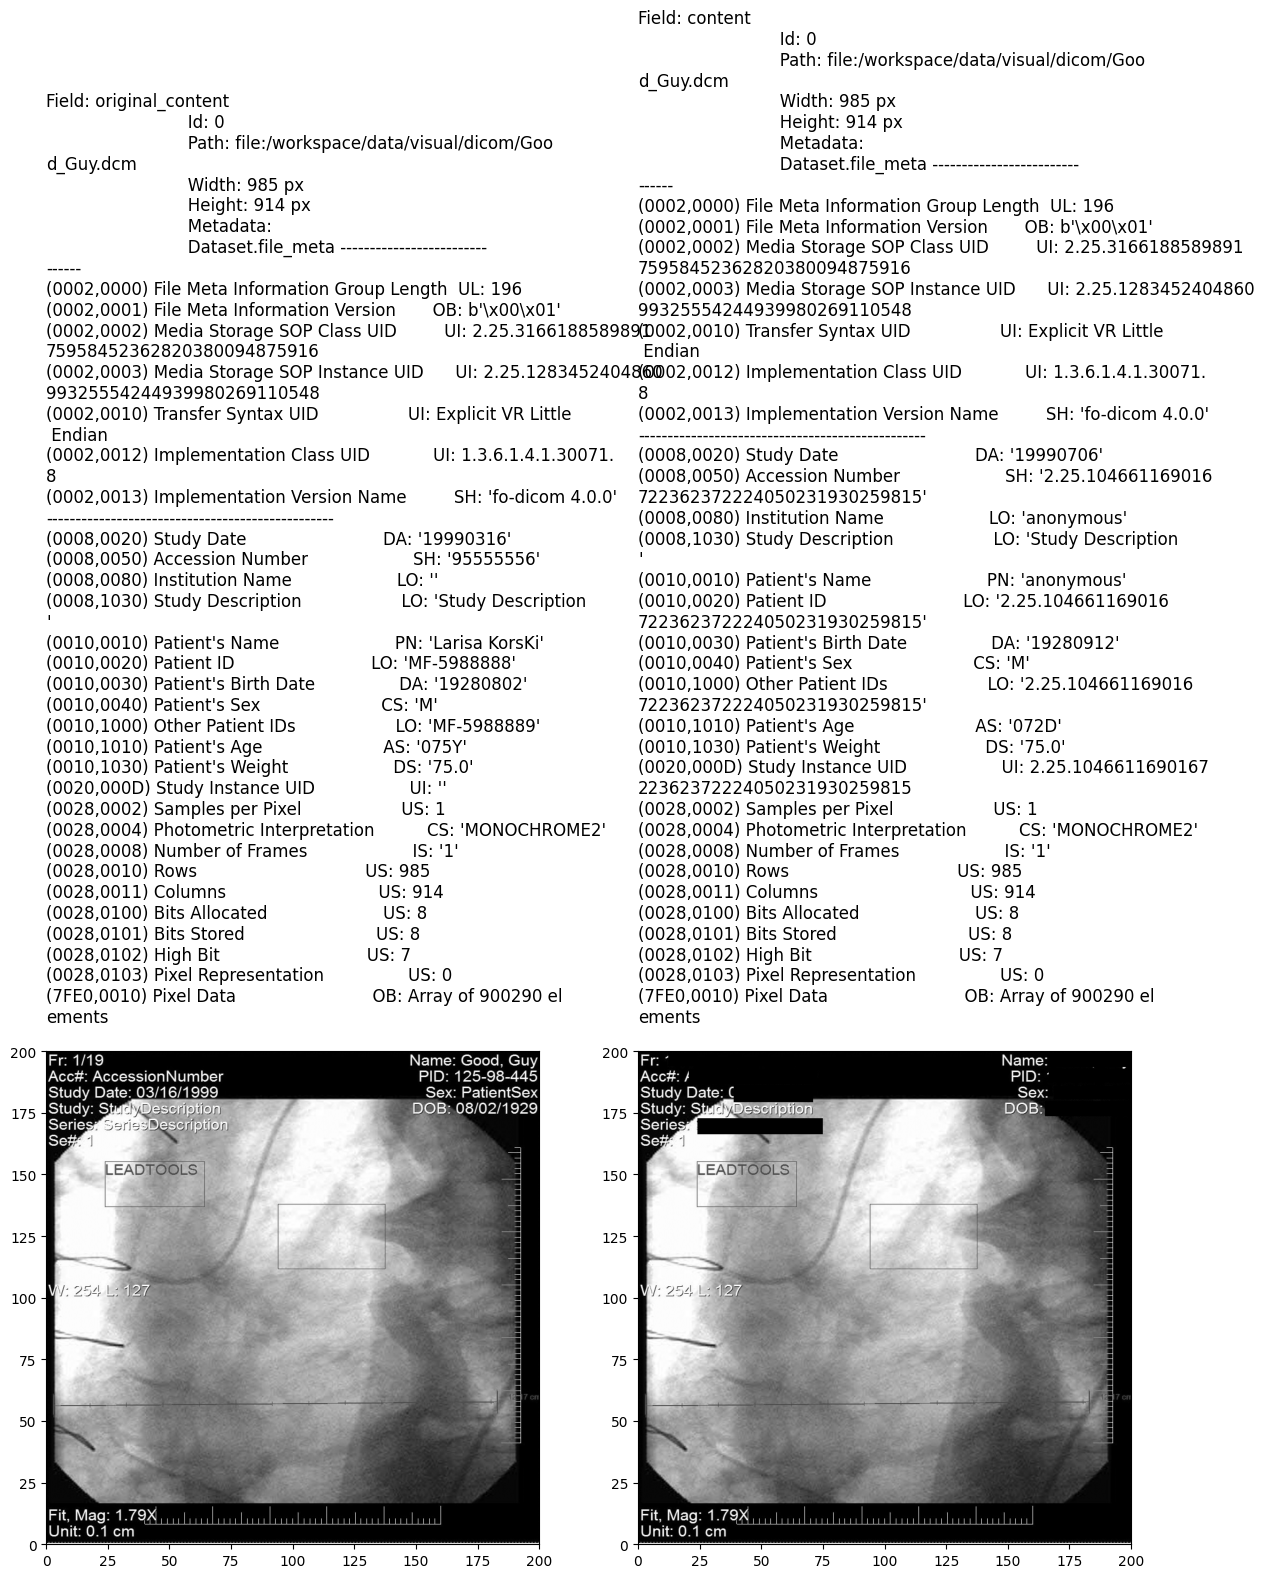

In [23]:
df = spark.read.format("binaryFile").load("./data/result/good_guy/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/visual/dicom/Good_Guy.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

<h2>Example 4: Deidentifying John Stiles DICOM Image</h2>

<p><strong>Input DICOM File Path:</strong> <code>./data/visual/dicom/John_Stiles.dcm</code></p>

<p><strong>Number of Frames in Input:</strong> 1</p>

<p><strong>Output Deidentified DICOM File Path:</strong> <code>./data/result/john_stiles/</code></p>

In [ ]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/John_Stiles.dcm")

dicom_full_pipe.fit(df).transform(df).write \
  .format("binaryFormat") \
  .option("type", "dicom") \
  .option("field", "dicom_meta_cleaned") \
  .option("nameField", "fileName") \
  .option("extension", "dcm") \
  .option("prefix", "de-id-") \
  .mode("overwrite") \
  .save("./data/result/john_stiles/")

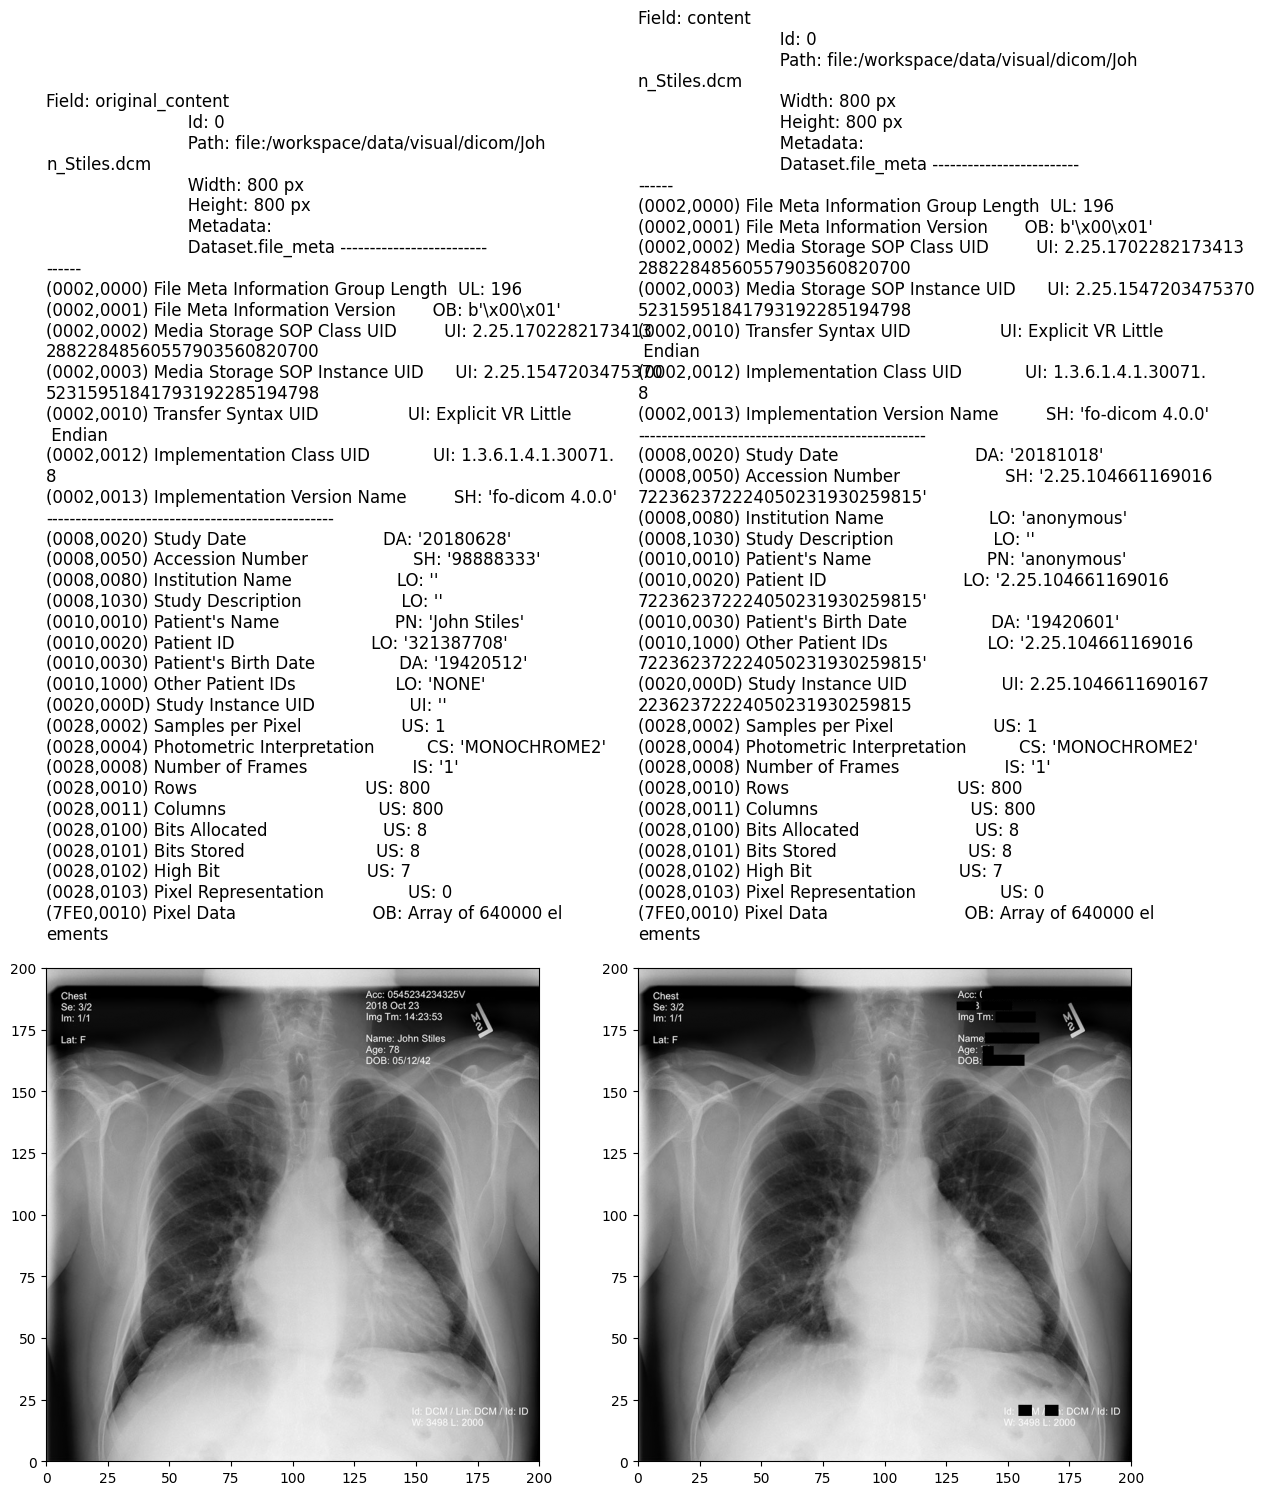

In [25]:
df = spark.read.format("binaryFile").load("./data/result/john_stiles/*.dcm").select("content")

df_orig = spark.read.format("binaryFile").load("./data/visual/dicom/John_Stiles.dcm").withColumnRenamed("content","original_content")

display_dicom(df.join(df_orig), "original_content,content")

In [26]:
import shutil
shutil.rmtree("./data/result")